In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits import Basemap
from matplotlib import cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files
from sklearn.preprocessing import StandardScaler

from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_apr_14 = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv')

In [ ]:
data_apr_14['Date/Time'] = pd.to_datetime(data_apr_14['Date/Time'], infer_datetime_format=True)
data_apr_14['Year'] = data_apr_14['Date/Time'].dt.year
data_apr_14['Month'] = data_apr_14['Date/Time'].dt.month
data_apr_14['Day'] = data_apr_14['Date/Time'].dt.day
data_apr_14['Weekday'] = data_apr_14['Date/Time'].dt.weekday
data_apr_14['Hour'] = data_apr_14['Date/Time'].dt.hour

data_apr_14.head()

,Date/Time,Lat,Lon,Base,Year,Month,Day,Weekday,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014,4,1,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014,4,1,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014,4,1,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014,4,1,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014,4,1,1,0


In [ ]:
data_apr_14.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
Year         0
Month        0
Day          0
Weekday      0
Hour         0
dtype: int64

In [ ]:
data_apr_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date/Time  564516 non-null  datetime64[ns]
 1   Lat        564516 non-null  float64       
 2   Lon        564516 non-null  float64       
 3   Base       564516 non-null  object        
 4   Year       564516 non-null  int64         
 5   Month      564516 non-null  int64         
 6   Day        564516 non-null  int64         
 7   Weekday    564516 non-null  int64         
 8   Hour       564516 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 38.8+ MB


# INPUT by user

In [ ]:
DAY = [10, 12] #day in month to explore the cluster, example : [10, 12] from 10 <= day < 12
HOUR= [6, 9] # take into account rides from 6 <= Hours < 9

MIN_SAMPLES = 15 #DBSCAN : number of minimum rides from that we consider a cluster
EPSILON = 1 #DBSCAN : distance between two pick-up places (in km2)

print('Find clusters (where to place the cars/taxi)')
print('Day : ', DAY)
print('From {} to {} h'.format(HOUR[0], HOUR[1]))

Find clusters (where to place the cars/taxi)
Day :  [10, 12]
From 6 to 9 h


#KMeans : find groups

###Find optimized number of clusters

In [ ]:
def define_cluster_Kmeans(data, day, hour, n_clusters_min=2, n_clusters_max=10):

    X = data[(data.Day>=day[0]) & (data.Day<day[1])  & (data.Hour>=hour[0]) & (data.Hour<hour[1])][['Lat', 'Lon']]
    
    distorsions = []
    silhouette = []
    for k in range(n_clusters_min, n_clusters_max):
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, n_init=3).fit(X)

        distorsions.append(kmeans.inertia_)

        y_kmeans = kmeans.predict(X)
        silhouette.append(silhouette_score(X, y_kmeans))

    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(n_clusters_min, n_clusters_max), distorsions, marker='o')
    plt.grid(True)
    plt.title('Elbow curve')

    plt.subplot(122)
    plt.plot(range(n_clusters_min,n_clusters_max), silhouette, marker='o')
    plt.title('Silhouette curve')
    plt.show()

    #find n_clusters at which silhouette_score is max.
    n_clusters = np.argmax(silhouette[1:]) + n_clusters_min + 1
    print('n_clusters :', n_clusters)

    #predict with Kmeans
    kmeans =  MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, n_init=3).fit(X)
    centers = kmeans.cluster_centers_
    y_kmeans = kmeans.predict(X)

    #join treated data and cluster_labels
    y_kmeans = pd.DataFrame(pd.DataFrame(y_kmeans).values, columns=['y_kmeans'])

    Xy = pd.concat([X.reset_index(), y_kmeans], axis=1).drop(['index'], axis=1)

    return n_clusters, centers, Xy

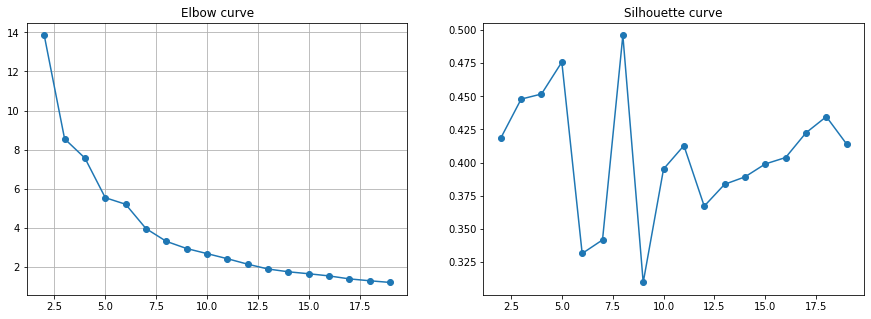

n_clusters : 8


In [ ]:
n_clusters_kmeans, centers_kmeans, Xy_kmeans = define_cluster_Kmeans(data=data_apr_14[['Lat', 'Lon', 'Day', 'Hour']],
                                                      day=DAY, hour=HOUR,
                                                      n_clusters_min=2, n_clusters_max=20)

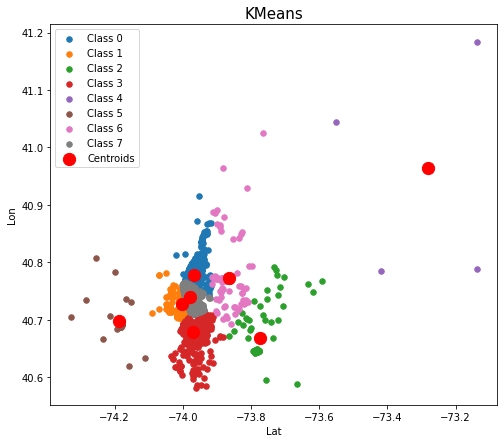

In [ ]:
colors = ['green', 'blue', 'pink', 'lime', 'brown', 'yellow', 'violet', 'gray', 'coral', 'olive']

plt.figure(figsize=(8, 7))
for i in range(n_clusters_kmeans):
    plt.scatter(Xy_kmeans[Xy_kmeans.y_kmeans == i]['Lon'], Xy_kmeans[Xy_kmeans.y_kmeans == i]['Lat'], s = 30, label = 'Class {}'.format(i))

plt.scatter(centers_kmeans[:,1], centers_kmeans[:,0], s = 150, c = 'red', label = 'Centroids')
plt.xlabel('Lat')
plt.ylabel('Lon')
plt.legend()
plt.title('KMeans', fontsize=15)
plt.show()

In [ ]:
fig = px.scatter_mapbox(Xy_kmeans, lat="Lat", lon="Lon", color="y_kmeans", height=400, size_max=15)
#fig = px.scatter_mapbox(centers_kmeans, lat=centers_kmeans[:,0], lon=centers_kmeans[:,1])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show() 

In [ ]:
layout_map = dict(
            #autosize=True,
            #hovermode='closest',
            width=950,
            height=580,
            margin=dict(l=0, r=0,b=0, t=0
                   ),
            #plot_bgcolor="#191A1A",
            #paper_bgcolor="#020202",
            mapbox=dict(
                    bearing=0,
                    center=dict(
                            lat=float(centers_kmeans[0,0]),
                            lon=float(centers_kmeans[0,1]),
                            ),
                    pitch=0,
                    zoom=10,
                    )
                )

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=Xy_kmeans['Lat'],
        lon=Xy_kmeans['Lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10, color=Xy_kmeans['y_kmeans'],opacity=0.7)))

fig.add_trace(go.Scattermapbox(
        lat=centers_kmeans[:,0],
        lon=centers_kmeans[:,1],
        mode='markers',
        marker=go.scattermapbox.Marker(size=25,color='red', opacity=0.8),
        hoverinfo='none'))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(layout_map)

#DBSCAN
https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb

In [ ]:
!pip install kneed

In [ ]:
def define_epsilon_dbscan(data, day, hour, n_neighbors=2):
#determining the optimal eps value
    X = data[(data.Day>=day[0]) & (data.Day<day[1])  & (data.Hour>=hour[0]) & (data.Hour<hour[1])][['Lat', 'Lon']]
    
    #transform X in radians
    nbrs = NearestNeighbors(n_neighbors=2, n_jobs=-1).fit(np.radians(X))

    distances, indices = nbrs.kneighbors(np.radians(X))
    distances = np.sort(distances[:,n_neighbors-1], axis=0)

    #distance in km2 per radian
    kms_per_radian = 6371.0088
    distances = distances*kms_per_radian

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(distances)
    plt.title('DBSCAN : Elbow curve')
    plt.show()

    # compute the distance (epsilon) at knee (on the plot)
    from kneed import KneeLocator
    kn = KneeLocator(x=range(0,len(distances)), y=distances, curve='convex', direction='increasing')
    epsilon_Knee = round(kn.knee_y, 2)
    print('Epsilon defind by Knee method in DBSCAN : ', epsilon_Knee)

    return X, epsilon_Knee


In [ ]:
def define_cluster_DBSCAN(data, day, hour, epsilon=0.5, min_samples=10):
    
    X, epsilon_Knee = define_epsilon_dbscan(data, day, hour, n_neighbors=2)

    if epsilon > epsilon_Knee:
        print('The input distance (epsilon={}) is too large'.format(epsilon))
        print('Replace by the maximal distance defined by Knee method : {}'.format(epsilon_Knee))
        epsilon = epsilon_Knee
    
    #DBSCAN
    kms_per_radian = 6371.0088
    epsilon = epsilon / kms_per_radian

    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
    
    #get nb of clusters
    num_clusters = len(set(dbscan.labels_)) - 1 #cluster n° (-1) is noise
    #get prediction
    y_dbscan = dbscan.fit_predict(np.radians(X))
    
    #concatenate data[Lat, Lon] with cluster_labels
    y_dbscan = pd.DataFrame(y_dbscan, columns=['y_dbscan'])
    Xy_dbscan = pd.concat([X.reset_index(), y_dbscan], axis=1).drop(['index'], axis=1)

    return num_clusters, Xy_dbscan

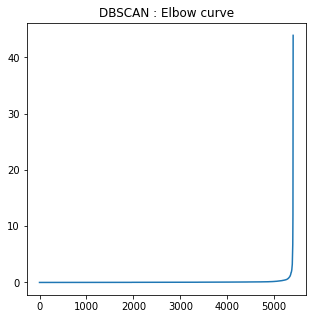

Epsilon defind by Knee method in DBSCAN :  1.2
n_clusters_dbscan : 5


In [ ]:
n_clusters_dbscan, Xy_dbscan = define_cluster_DBSCAN(data=data_apr_14[['Lat', 'Lon', 'Day', 'Hour']],
                                                     day=DAY, hour=HOUR, 
                                                     epsilon=EPSILON, min_samples=MIN_SAMPLES)
print('n_clusters_dbscan :', n_clusters_dbscan)

In [ ]:
fig = px.scatter_mapbox(Xy_dbscan, lat="Lat", lon="Lon", color="y_dbscan")
#fig = px.scatter_mapbox(centers_kmeans, lat=centers_kmeans[:,0], lon=centers_kmeans[:,1])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.update_layout(layout_map)
fig.show() 
print('Class (-1) is Noise')

Class (-1) is Noise


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=Xy_dbscan['Lat'],
        lon=Xy_dbscan['Lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10, color=Xy_dbscan['y_dbscan'],opacity=0.7,
            colorscale= 'rainbow', showscale=True,
            colorbar=dict(thickness=20, 
                          tickvals=[Xy_dbscan['y_dbscan'].min(),0, Xy_dbscan['y_dbscan'].max()]))))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(layout_map)
fig.show()
print('Class -1 if Noise')

Class -1 if Noise
